In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix


In [8]:
df = pd.read_csv('../data/customer_churn_dataset-testing-master.csv')

In [9]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [11]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [12]:
X = df.drop(columns=['Churn', 'CustomerID'])
y = df['Churn']

In [13]:
categorial_features = [
    'Gender',
    'Subscription Type',
    'Contract Length'
]
numerical_features = [
    'Age',
    'Tenure',
    'Usage Frequency',
    'Support Calls',
    'Payment Delay',
    'Total Spend',
    'Last Interaction'
]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features),
        ('num', 'passthrough', numerical_features)
    ]
)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [17]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

In [18]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
# получаем имена признаков после one-hot
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# коэффициенты модели
coefficients = pipeline.named_steps['model'].coef_[0]

# делаем датафрейм для удобного просмотра
importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

importance.head(10)  # топ 10 самых сильных признаков

,feature,coefficient
11,num__Support Calls,0.332654
12,num__Payment Delay,0.213904
9,num__Tenure,0.034973
8,num__Age,0.019433
14,num__Last Interaction,-0.000666
13,num__Total Spend,-0.000993
10,num__Usage Frequency,-0.059402
6,cat__Contract Length_Monthly,-0.692256
0,cat__Gender_Female,-0.889616
2,cat__Subscription Type_Basic,-0.918012


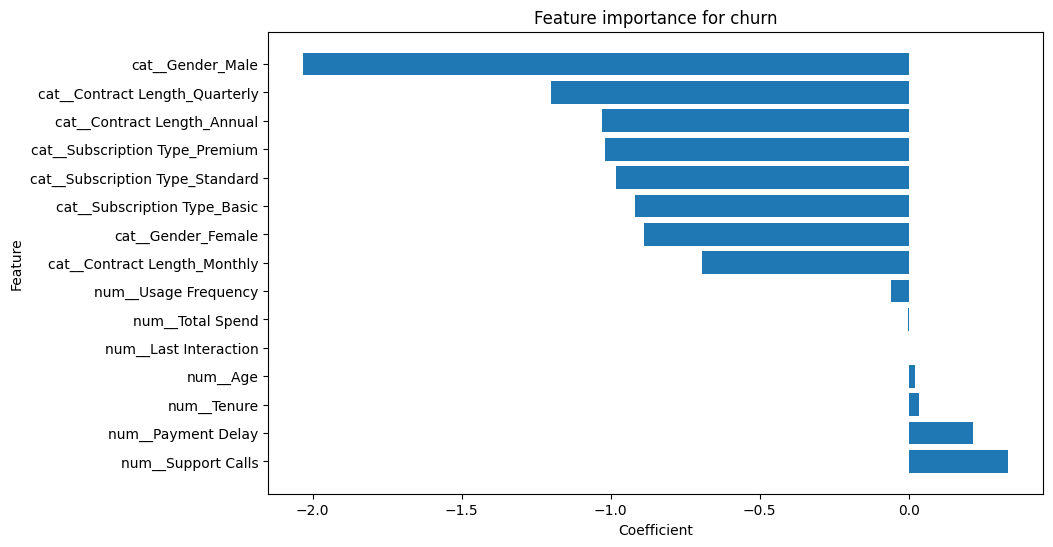

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature importance for churn')
plt.show()

In [21]:
# предсказания на тесте
y_pred = pipeline.predict(X_test)

# матрица ошибок
cm = confusion_matrix(y_test, y_pred)
cm

array([[5625, 1151],
       [1075, 5024]])

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6776
           1       0.81      0.82      0.82      6099

    accuracy                           0.83     12875
   macro avg       0.83      0.83      0.83     12875
weighted avg       0.83      0.83      0.83     12875



In [23]:
y_proba = pipeline.predict_proba(X_test)[:, 1]  # вероятность churn

### Baseline модель

В качестве baseline использованя Logistic Regression.
При пороге 0.5 recall по churn = 0.82.
Для бизнеса важнее минимизировать FN, поэтому рассматривается снижение порога.

In [24]:
y_pred_04 = (y_proba >= 0.4).astype(int)

In [25]:
cm_new = confusion_matrix(y_test, y_pred_04)

In [26]:
cm_new

array([[5217, 1559],
       [ 755, 5344]])

In [27]:
print(classification_report(y_test, y_pred_04))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      6776
           1       0.77      0.88      0.82      6099

    accuracy                           0.82     12875
   macro avg       0.82      0.82      0.82     12875
weighted avg       0.83      0.82      0.82     12875



In [28]:
thresholds = np.arange(0.1, 0.9, 0.05)
results = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t)
    results.append((t, recall, precision))
results

[(np.float64(0.1), 0.9742580750942778, 0.6115056087269733),
 (np.float64(0.15000000000000002), 0.9619609772093786, 0.6472859664607238),
 (np.float64(0.20000000000000004), 0.9480242662731595, 0.6786384976525821),
 (np.float64(0.25000000000000006), 0.9349073618626004, 0.7030826140567201),
 (np.float64(0.30000000000000004), 0.9191670765699295, 0.7292832054117341),
 (np.float64(0.3500000000000001), 0.897360222987375, 0.7495206792659546),
 (np.float64(0.40000000000000013), 0.8762092146253484, 0.7741561639866724),
 (np.float64(0.45000000000000007), 0.8512870962452861, 0.7961969023155958),
 (np.float64(0.5000000000000001), 0.823741596983112, 0.8136032388663967),
 (np.float64(0.5500000000000002), 0.7873421872438104, 0.8296475466482377),
 (np.float64(0.6000000000000002), 0.749303164453189, 0.8477091448710814),
 (np.float64(0.6500000000000001), 0.6991310050828005, 0.8610662358642972),
 (np.float64(0.7000000000000002), 0.6561731431382194, 0.8776315789473684),
 (np.float64(0.7500000000000002), 0.5

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

In [30]:
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

0.903000845165358

### Threshold selection

Для задачи churn приоритетом является минимизация False Negative (пропущенных уходящих клиентов).
При снижении порога классификации наблюдается рост recall за счёт снижения precision.

| Threshold | Recall (churn) | Precision (churn) |
|----------|----------------|-------------------|
| 0.10     | ~0.97          | ~0.61             |
| 0.35     | ~0.90          | ~0.75             |
| 0.50     | ~0.82          | ~0.81             |

В качестве рабочего выбран threshold = 0.35, обеспечивающий баланс между высокой полнотой и приемлемой точностью.

1️⃣ Бизнес-гипотезы на основе модели

Исходя из нашых признаков и коэффициентов:

Гипотеза 1: Частые обращения в поддержку → повышенный риск ухода
Основание: Support Calls +0.33
Тест: выделить клиентов с ≥ N обращений и проверить фактический churn
Действие: создать программу proactive support для таких клиентов

Гипотеза 2: Задержки платежей → сигнал о риске
Основание: Payment Delay +0.21
Тест: сегмент клиентов с задержками > X дней
Действие: автоматизированные напоминания и персональные предложения, чтобы снизить churn

Гипотеза 3: Тип подписки и контракт влияет на удержание
Основание: Subscription Type_Basic -0.92, Contract Length_Monthly -0.69
Интерпретация: базовые и ежемесячные подписки уходят реже
Действие: использовать гибкую тарифную стратегию для премиальных клиентов, которые чаще уходят

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [49]:
categorical_features = ['Gender', 'Subscription Type', 'Contract Length']
numeric_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# обучаем pipeline
rf_pipeline.fit(X_train, y_train)

# достаём модель
rf_model = rf_pipeline.named_steps['model']

# важность
importances = rf_model.feature_importances_  ### feature_importance_ всегда соответствует признакам ПОСЛЕ трансформаций

# имена признаков
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# проверка
#print(len(importances), len(feature_names))

# DataFrame
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

rf_importance.head(10)


,feature,importance
4,num__Payment Delay,0.444717
3,num__Support Calls,0.163500
1,num__Tenure,0.102799
2,num__Usage Frequency,0.080960
7,cat__Gender_Male,0.073298
5,num__Total Spend,0.047130
0,num__Age,0.041765
10,cat__Contract Length_Monthly,0.025525
6,num__Last Interaction,0.009657
11,cat__Contract Length_Quarterly,0.007026


In [50]:
feature_groups = {
    'Payment Behavior': [
        'num__Payment Delay',
        'num__Total Spend'
    ],
    'Customer Experience': [
        'num__Support Calls',
        'num__Last Interaction'
    ],
    'Engagement': [
        'num__Usage Frequency',
        'num__Tenure'
    ],
    'Demographics': [
        'num__Age',
        'cat__Gender_Male'
    ],
    'Contract': [
        'cat__Contract Length_Monthly',
        'cat__Contract Length_Quarterly'
    ]
}

In [54]:
group_importance = {}

for group, features in feature_groups.items():
    group_importance[group] = rf_importance[
        rf_importance['feature'].isin(features)
    ]['importance'].sum()

group_importance = (
    pd.DataFrame.from_dict(group_importance, orient='index', columns=['importance'])
    .sort_values(by='importance', ascending=False)
)
group_importance['share_of_model'] = group_importance['importance']
group_importance

,importance,share_of_model
Payment Behavior,0.491847,0.491847
Engagement,0.183759,0.183759
Customer Experience,0.173157,0.173157
Demographics,0.115064,0.115064
Contract,0.032551,0.032551


In [57]:
churn_proba = rf_pipeline.predict_proba(X_test)[:, 1]

In [58]:
risk_df = X_test.copy()
risk_df['churn_proba'] = churn_proba
risk_df['actual_churn'] = y_test.values

In [62]:
def risk_segment(p):
    if p < 0.3:
        return 'Low Risk'
    elif p < 0.6:
        return 'Medium Risk'
    else:
        return 'High Risk'

risk_df['risk_segment'] = risk_df['churn_proba'].apply(risk_segment)

In [67]:
risk_df['risk_segment'].value_counts(normalize=True)
risk_df.groupby('risk_segment')['actual_churn'].mean().sort_values(ascending=False)

risk_segment
High Risk      0.999835
Medium Risk    0.318182
Low Risk       0.000149
Name: actual_churn, dtype: float64